In [1]:
import os
import glob
import umap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential, Model
from keras.applications import vgg16
# from keras.applications import resnet50
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.layers.merge import Concatenate
# from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from skimage.io import imread, imshow
from skimage.transform import resize
# import imgaug as ia
# from imgaug import augmenters as iaa
from keras import backend as K
import tensorflow as tf
from collections import defaultdict, Counter
# print(os.listdir("../input"))
from sklearn.decomposition import PCA
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### 데이터 불러오기

In [3]:
PATH=Path('./dataset/')

# Path to training images and corresponding labels provided as numpy arrays
train_images_path = PATH/"kmnist-train-imgs.npz"
train_labels_path = PATH/"kmnist-train-labels.npz"

# Path to the test images and corresponding labels
test_images_path = PATH/"kmnist-test-imgs.npz"
test_labels_path = PATH/"kmnist-test-labels.npz"

In [4]:
# Load the data from the corresponding npz files
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_images_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

In [5]:
# train, test data 보기
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [25]:
train_labels.shape, test_labels.shape

((60000,), (10000,))

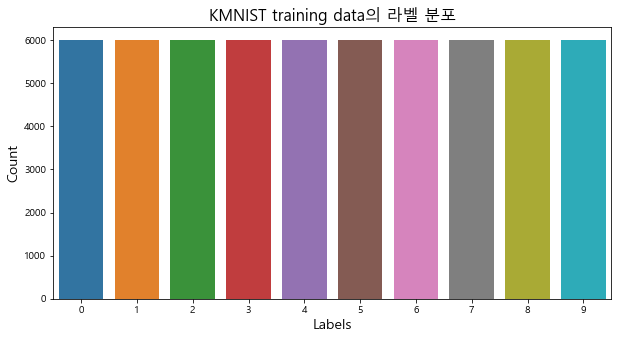

In [6]:
labels=np.unique(train_labels)
frequency_count = np.bincount(train_labels)

# Visualize 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("KMNIST training data의 라벨 분포", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

- train data의 각 label에 대한 무작위 샘플을 얻기
- 각 캐릭터(label)의 이미지가 어떻게 생겼는지, 같은 클래스의 샘플 간 변동은 어느 정도인지 알아보기 위함
- 어떻게 정확하게 그룹화할 수 있을까?

In [7]:
random_samples=[]
for i in range(10):
    samples = train_images[np.where(train_labels == i)][:5] # 5개만
    random_samples.append(samples)
    
# Converting list into a numpy array
random_samples = np.array(random_samples)

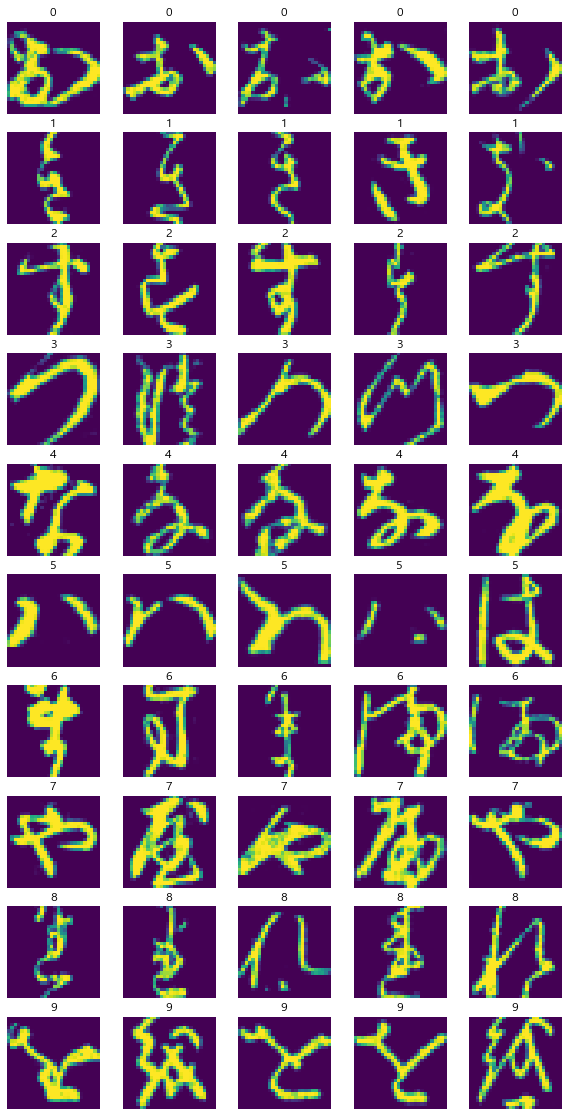

In [8]:
# random_samples 시각화
f, ax = plt.subplots(10,5, figsize=(10,20))
for i, j in enumerate(random_samples):
    for n in range(5):
        ax[i, n].imshow(random_samples[i][n])

        ax[i, n].set_title(str(i))
        ax[i, n].axis('off') # x, y축 눈금 제거
        ax[i, n].set_aspect('equal') # x, y축 비율

## t-SNE & UMAP
- 고차원 데이터의 시각화
- t-SNE => 계산 비용이 큼, t-SNE의 sklearn 구현 속도 느림. 단일 코어에서 실행되며 메모리가 사용량이 매우 큼. => 샘플 수를 최대 5K로 제한
- UMAP : 30K에서 50K 정도의 더 큰 샘플 사이즈를 사용

- 함께 사용하는 이유
    * t-SNE와 UMAP을 각각 사용했을 때, 모든 label이 다른 cluster로 완벽하게 분리됨.
    * 대부분의 실제 데이터는 명확하지 않음.

In [9]:
labels_dict = dict([(0, u"\u304A"), (1, u"\u304D"), (2, u"\u3059"), (3, u"\u3064"),
                    (4, u"\u306A"), (5, u"\u306F"), (6, u"\u307E"), (7, u"\u3084"),
                    (8, u"\u308C"), (9, u"\u3093")])
print(labels_dict)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'}


In [10]:
# A handy-dandy function to get randomly sampled data 
def get_random_samples(nb_indices):
    # Choose indices randomly 
    random_indices = np.random.choice(nb_indices, size=nb_indices, replace=False)

    # Get the data corresponding to these indices
    random_train_images = train_images[random_indices].astype(np.float32)
    random_train_images /=255.
    random_train_images = random_train_images.reshape(nb_indices, 28*28)
    random_train_labels = train_labels[random_indices]
    labels = np.unique(random_train_labels)
    return random_indices, random_train_images, random_train_labels, labels

In [11]:
# #Get randomly sampled data
# nb_indices = 5000
# random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

# # Get the actual labels from the labels dictionary
# labels_name = [labels_dict[x] for x in labels]

# # Get a t-SNE instance
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# # Fit tsne to the data
# random_train_2D = tsne.fit_transform(random_train_images)


# fig = plt.figure(figsize=(10, 8))

# for i, label in zip(labels, labels_name):
#     sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
#                 random_train_2D[random_train_labels == i, 1], 
#                 label=i, s=18)

# plt.title("Visualizating KMNIST embeddings using tSNE", fontsize=16)
# plt.legend()
# plt.show()

In [12]:
# # Let's try UMAP now.
# nb_indices = 10000
# random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

# embedding = umap.UMAP(n_components=2, metric='correlation', min_dist=0.8)
# random_train_2D = embedding.fit_transform(random_train_images)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111) #projection='3d')

# for i, label in zip(labels, labels):
#     sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
#                 random_train_2D[random_train_labels == i, 1], 
#                 label=label, s=15)
# plt.title("Visualiza KMNIST embeddings using UMAP ", fontsize=16)
# plt.legend()
# plt.show()

## 전처리

In [13]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# input shape
input_shape = (img_rows, img_cols, 1)

In [20]:
# Process the train and test data in the exact same manner as done for MNIST
x_train = train_images/255.0
x_test = test_images/255.0

# x_train = x_train.reshape(x_train.shape[0], *input_shape)
# x_test = x_test.reshape(x_test.shape[0], *input_shape)

y_train=train_labels
y_test=test_labels
# # convert class vectors to binary class matrices
# y_train = to_categorical(train_labels, num_classes)
# y_test = to_categorical(test_labels, num_classes)

In [21]:
x_train.shape

(60000, 28, 28)

In [22]:
# Build and train the model. 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [28]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 54s 114ms/step - loss: 0.4101 - accuracy: 0.8736 - val_loss: 0.3523 - val_accuracy: 0.8952
Epoch 2/12
469/469 [==============================] - 59s 125ms/step - loss: 0.1794 - accuracy: 0.9448 - val_loss: 0.2819 - val_accuracy: 0.9216
Epoch 3/12
469/469 [==============================] - 60s 127ms/step - loss: 0.1339 - accuracy: 0.9589 - val_loss: 0.2550 - val_accuracy: 0.9296
Epoch 4/12
469/469 [==============================] - 60s 128ms/step - loss: 0.1071 - accuracy: 0.9661 - val_loss: 0.2173 - val_accuracy: 0.9386
Epoch 5/12
469/469 [==============================] - 61s 130ms/step - loss: 0.0898 - accuracy: 0.9715 - val_loss: 0.2147 - val_accuracy: 0.9414
Epoch 6/12
469/469 [==============================] - 62s 132ms/step - loss: 0.0801 - accuracy: 0.9742 - val_loss: 0.2232 - val_accuracy: 0.9441
Epoch 7/12
469/469 [==============================] - 60s 127ms/step - loss: 0.0686 - accuracy: 0.9776 - val_loss: 0.2172 - val_ac